In [41]:
# здесь только импорт
import requests, json
import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np
import math
import urllib2
from bs4 import BeautifulSoup
import string
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits import mplot3d
import copy
from joblib import Parallel, delayed, wrap_non_picklable_objects, parallel_backend
from multiprocessing import Pool, cpu_count
from tqdm import tqdm_notebook
from fake_useragent import UserAgent
import re
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [3]:
# посылаем запросы через хост ТОРа
import socks
import socket
socks.set_default_proxy(socks.SOCKS5, "localhost", 9150)
socket.socket = socks.socksocket

In [4]:
# если вдруг захочется проверить свой IP
def checkIP():
    ip = requests.get('http://checkip.dyndns.org').content
    soup = BeautifulSoup(ip, 'html.parser')
    print(soup.find('body').text)

checkIP()

Current IP Address: 185.220.101.17


In [5]:
# функция парсинга объектов постранично
def parsing_new(i):
    try:
        response = requests.get('https://www.domofond.ru/prodazha-kvartiry-samara-c2415?Page=' + str(i), headers={'User-Agent': UserAgent().chrome})
        html = response.content
        soup = BeautifulSoup(html,'html.parser')
        string_soup = str(soup)

        indexes = [m.start() for m in re.finditer('itemUrl', string_soup)]
        for j in range(len(indexes)):
            index_finish = string.find(string_soup[(indexes[j]+11):], ',')
            hrefs = string_soup[(indexes[j]+11):(indexes[j]+10+index_finish)]
            clean_hrefs = 'https://www.domofond.ru/' + hrefs
            our_links.append(clean_hrefs)
    except:
        null

In [6]:
# функция парсинга для одной ссылки
def parse_single_flat(i):
    try:
        # забираем стоимость квадратного метра

        response = requests.get(our_links[i])
        html = response.content
        soup = BeautifulSoup(html,'html.parser')
        soup_str = str(soup)
        index_start = string.find(soup_str, '"Цена за м²","value"')
        index_finish = string.find(soup_str[index_start+30:], '₽')
        sq_m_price_str = soup_str[(index_start+30):(index_start+30+index_finish)]
        sq_m_price_str = sq_m_price_str.replace(' ', '')
        try:
            sq_m_price = float(sq_m_price_str)
        except:
            sq_m_price = None

        # забираем координаты объекта (широта и долгота)
        try:
            str_start = string.find(soup_str, 'longitude') + 11
            str_finish = string.find(soup_str, 'latitude') - 2
            coord_1 = float(soup_str[str_start:str_finish])
        except:
            coord_1 = None

        try:
            str_start = string.find(soup_str, 'latitude') + 10
            str_finish = string.find(soup_str, 'latitude') + 18
            coord_2 = float(soup_str[str_start:str_finish])
        except:
            coord_2 = None

        dataset_flats.loc[i, 'lng'] = coord_1
        dataset_flats.loc[i, 'lat'] = coord_2
        dataset_flats.loc[i, 'sq_meter_price'] = sq_m_price
    except:
        dataset_flats.loc[i, 'lng'] = None
        dataset_flats.loc[i, 'lat'] = None
        dataset_flats.loc[i, 'sq_meter_price'] = None

In [7]:
# собираем ссылки на квартиры

our_links = list()

with parallel_backend('threading', n_jobs = 8):
    Parallel()(delayed(parsing_new)(m) for m in tqdm_notebook(range(360)))

In [8]:
# заносим список в датасет
dataset_flats = pd.DataFrame(our_links, columns=['link'])

In [9]:
# ходим по ссылкам на квартиры и собираем геопозицию и цену квадратного метра

with parallel_backend('threading', n_jobs = 8):
    Parallel()(delayed(parse_single_flat)(m) for m in tqdm_notebook(range(len(our_links))))

In [10]:
# визуалзируем данные
dataset_flats.loc[dataset_flats['lng'] > 53, 'lng'] = None
dataset_flats.loc[dataset_flats['lng'] < 49.5, 'lng'] = None
x_data = dataset_flats.dropna()['lng']
y_data = dataset_flats.dropna()['lat']
z_data = dataset_flats.dropna()['sq_meter_price'].sort_values(ascending = True)

In [54]:
abs_err_list = list()

samara_only_dropped = samara_only.dropna()
X = samara_only_dropped[['lng', 'lat']].values
y = samara_only_dropped[['sq_meter_price']].values

for i in range(2, len(X)):
    X_cut = X[:i]
    y_cut = y[:i]
    
    X_train, X_test, y_train, y_test = train_test_split(X_cut, y_cut, test_size=0.2, random_state=0)

    regressor = LinearRegression()  
    regressor.fit(X_train, y_train)

    y_pred = regressor.predict(X_test)
    
    abs_err = metrics.mean_absolute_error(y_test, y_pred)
    abs_err_list.append(abs_err)

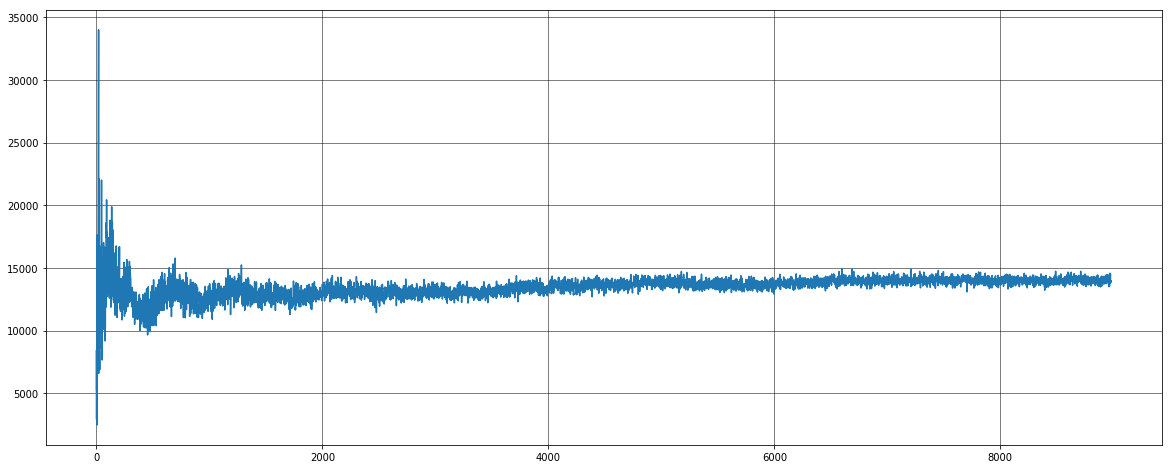

In [56]:
plt.figure(figsize=(20,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='black')
plt.plot(abs_err_list)

In [60]:
# Случайный лес

from sklearn.ensemble import RandomForestRegressor

abs_err_list_rf = list()


for i in tqdm_notebook(range(2, len(X))):
    X_cut = X[:i]
    y_cut = y[:i]
    
    X_train, X_test, y_train, y_test = train_test_split(X_cut, y_cut, test_size=0.2, random_state=0)

    rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
    rf.fit(X_train, y_train.ravel())
    
    predictions = rf.predict(X_test)
    
    abs_err_rf = metrics.mean_absolute_error(y_test, predictions)
    abs_err_list_rf.append(abs_err_rf)

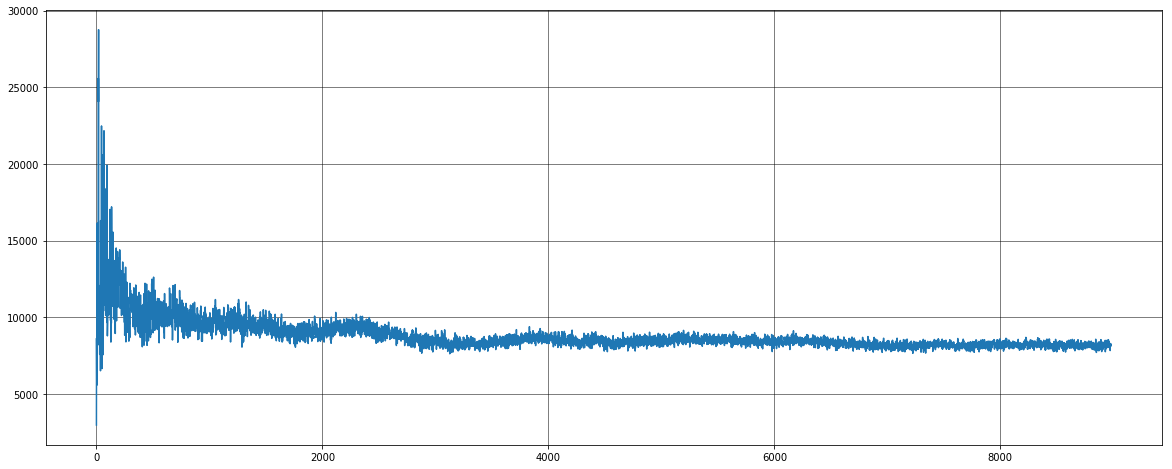

In [61]:
plt.figure(figsize=(20,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='black')
plt.plot(abs_err_list_rf)

In [29]:
samara_only_dropped.to_excel('dropped_table.xlsx')

In [30]:
samara_only_dropped = samara_only_dropped.reset_index(drop = True)
samara_only_dropped['Predicted'] = pred_table['Predicted']

In [31]:
samara_only_dropped['Discount'] = (samara_only_dropped['Predicted'] - samara_only_dropped['sq_meter_price']) / samara_only_dropped['Predicted']

In [32]:
list_of_k = list()
for j in range(101):
    k = 0
    for i in range(len(samara_only_dropped)):
        if (samara_only_dropped.loc[i, 'Discount'] < (float(j)/100)) & (samara_only_dropped.loc[i, 'Discount'] > (-float(j)/100)):
            k = k+1
    list_of_k.append(100 * float(k) / len(samara_only_dropped))

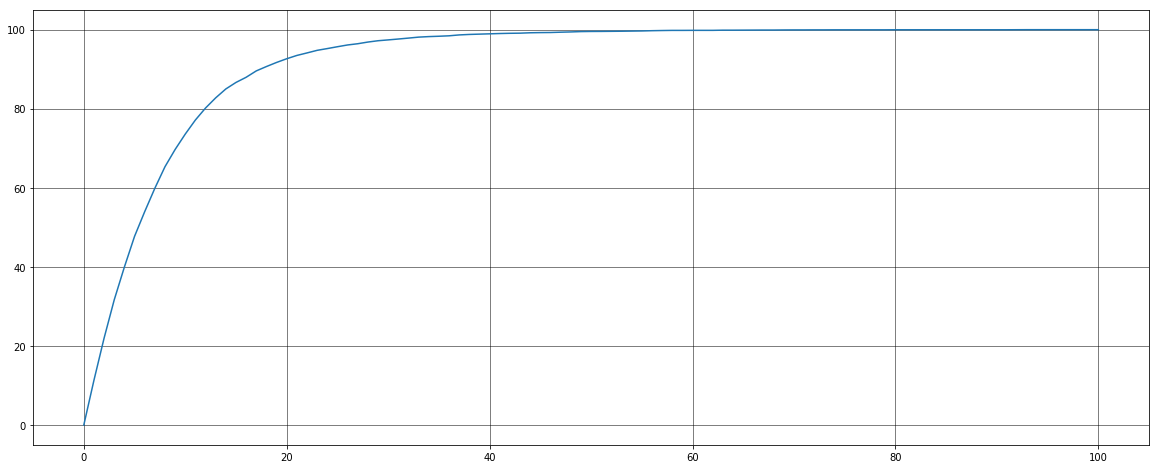

In [33]:
plt.figure(figsize=(20,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='black')
plt.plot(list_of_k)